In [13]:
# %%

# import math # roundは組み込み関数のため不要
# jax関連のライブラリを全てインポート
import numpy as np
from sympy import symbols
from DegenerateDiffusionProcess import DegenerateDiffusionProcess
# from LikelihoodEvaluator import LikelihoodEvaluator
# from ParameterEstimator import ParameterEstimator
import sympy as sp
from sympy import Array
import matplotlib.pyplot as plt

In [14]:
x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])

# インスタンス
FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

# Likelihood_FN = LikelihoodEvaluator(FNmodel)

In [17]:
true_theta1 = np.array([0.3])
true_theta2 = np.array([1.5, 0.8])
true_theta3 = np.array([0.1, 0.0])
true_theta = (true_theta1, true_theta2, true_theta3)
t_max = 50
burn_out = 50
h = 0.1

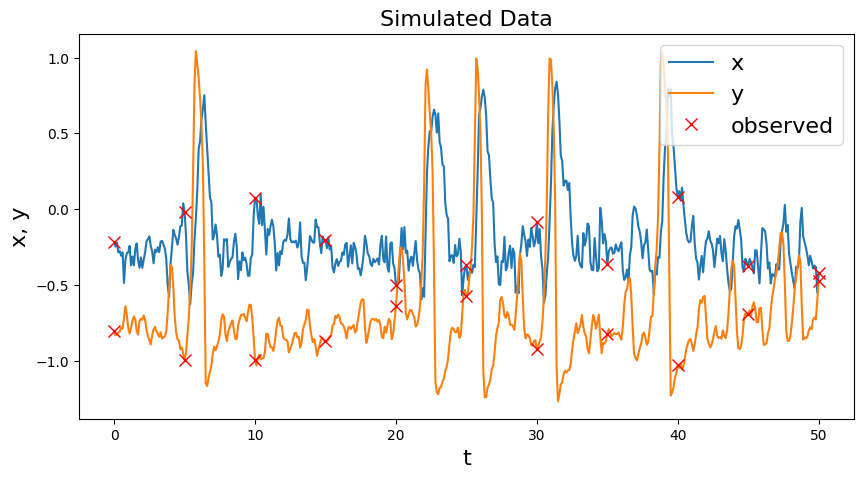

In [26]:
x_series, y_series = FNmodel.simulate(true_theta=true_theta, t_max=t_max, burn_out=burn_out, h=h)
t = np.linspace(0, t_max, len(x_series))
plt.figure(figsize=(10, 5))
plt.plot(t, x_series, label="x")
plt.plot(t, y_series, label="y")
plt.xlabel("t", fontsize=16)
plt.ylabel("x, y", fontsize=16)
plt.title("Simulated Data", fontsize=16)
#5秒間隔で縦線をプロット
#5秒間隔でグラフ上の点に大きなまるを表示
for i in range(0, len(t), 50):
    if i == 0:
        plt.plot(t[i], x_series[i], 'x', color='red', markersize=8, label='observed')
        plt.plot(t[i], y_series[i], 'x', color='red', markersize=8)
    else:
        plt.plot(t[i], x_series[i], 'x', color='red', markersize=8)
        plt.plot(t[i], y_series[i], 'x', color='red', markersize=8)
plt.legend(fontsize=16)
plt.show()

In [5]:
class AdaptiveEstimate_DegenerateDiffusionProcess(ParameterEstimator):
    def __init__(self, model, true_theta, t_max, burn_out, h) -> None:
        self.model = model
        self.true_theta = true_theta
        self.t_max = t_max
        self.burn_out = burn_out
        self.h = h

    def estimate(self):
        # Step 1: データ生成
        x_series, y_series = self.model.simulate(
            true_theta=self.true_theta,
            t_max=self.t_max,
            burn_out=self.burn_out,
            h=self.h,
        )
        # Step 2: パラメータ推定
        param_estimator = ParameterEstimator(
            model=self.model,
            x_series=x_series,
            y_series=y_series,
            t_max=self.t_max,
            burn_out=self.burn_out,
            h=self.h,
        )
        return param_estimator.estimate()

In [6]:
# project_imports.py から必要なものをインポートすることを想定
from DegenerateDiffusionProcess import DegenerateDiffusionProcess
from LikelihoodEvaluator import LikelihoodEvaluator
from ParameterEstimator import ParameterEstimator  # 継承元
from project_imports import List, Tuple, np  # その他必要に応じて


class AdaptiveEstimate_DegenerateDiffusionProcess(ParameterEstimator):
    """DegenerateDiffusionProcessモデルに対する適応的推定を実行するクラス。
    ParameterEstimatorを継承し、特定の推定戦略を実装する。.
    """

    def __init__(
        self,
        model: DegenerateDiffusionProcess,
        data_x: np.ndarray,
        data_y: np.ndarray,
        h: float,
        bounds: Tuple[List[Tuple[float]]],
    ) -> None:
        """Args:
        model (DegenerateDiffusionProcess): DegenerateDiffusionProcess のインスタンス。
        k0 (int): 推定の最大反復回数や次数に関連するパラメータ。
        data_x (np.ndarray): 観測された状態変数xの時系列データ。
        data_y (np.ndarray): 観測された観測変数yの時系列データ。
        h (float): データの間隔。.

        """
        if not isinstance(model, DegenerateDiffusionProcess):
            msg = "model must be an instance of DegenerateDiffusionProcess."
            raise TypeError(msg)

        self.model = model
        self.likelihood_evaluator = LikelihoodEvaluator(model)  # 内部で尤度評価器を生成
        self.data_x = data_x
        self.data_y = data_y
        self.h = h
        self.num_params_theta1 = model.theta_1.shape[0] if hasattr(model.theta_1, "shape") else 0
        self.num_params_theta2 = model.theta_2.shape[0] if hasattr(model.theta_2, "shape") else 0
        self.num_params_theta3 = model.theta_3.shape[0] if hasattr(model.theta_3, "shape") else 0
        self.bounds_theta1 = bounds[0]
        self.bounds_theta2 = bounds[1]
        self.bounds_theta3 = bounds[2]

        # 推定結果を格納する変数
        self.estimated_theta_history = []  # 各ステップのthetaを保存する場合
        self.current_estimated_theta = None

    def run_estimation_step(
        self,
        k: int,  # 現在の反復ステップ (論文中の k に対応)
        bar_theta: Tuple[
            np.ndarray, np.ndarray, np.ndarray
        ],  # (theta_hat_0_1, theta_hat_0_2, theta_hat_0_3)
        quasilikelihood_type: str,  # 'V1_prime', 'V1', 'V2', 'V3' のいずれか
        estimation_method_A: str,  # 'M', 'B', or 'S'
    ) -> np.ndarray:
        bar_theta1, bar_theta2, bar_theta3 = bar_theta
        if quasilikelihood_type == "V1_prime":
            # V1' は theta_1 を最適化
            evaluator_func = self.likelihood_evaluator.make_quasi_likelihood_v1_prime_evaluator(
                self.data_x, self.data_y, self.h, k
            )

            # ParameterEstimator.m_estimate は目的関数を最小化するので、尤度は最大化（負の尤度を最小化）
            def objectiv_func(theta_1_val):
                return evaluator_func(theta_1_val, bar_theta1, bar_theta2, bar_theta3)

            initial_guess = bar_theta1
            bounds = self.bounds_theta1
        elif quasilikelihood_type == "V1":
            # V1 は theta_1 を最適化
            evaluator_func = self.likelihood_evaluator.make_quasi_likelihood_v1_evaluator(
                self.data_x, self.data_y, self.h, k
            )

            def objectiv_func(theta_1_val):
                return evaluator_func(theta_1_val, bar_theta1, bar_theta2, bar_theta3)

            initial_guess = bar_theta1
            bounds = self.bounds_theta1
        elif quasilikelihood_type == "V2":
            # V2 は theta_2 を最適化
            evaluator_func = self.likelihood_evaluator.make_quasi_likelihood_v2_evaluator(
                self.data_x, self.data_y, self.h, k
            )

            def objectiv_func(theta_2_val):
                return evaluator_func(theta_2_val, bar_theta1, bar_theta2, bar_theta3)

            initial_guess = bar_theta2
            bounds = self.bounds_theta2
        elif quasilikelihood_type == "V3":
            # V3 は theta_3 を最適化
            evaluator_func = self.likelihood_evaluator.make_quasi_likelihood_v3_evaluator(
                self.data_x, self.data_y, self.h, k
            )

            def objectiv_func(theta_3_val):
                return evaluator_func(theta_3_val, bar_theta1, bar_theta2, bar_theta3)

            initial_guess = bar_theta3
            bounds = self.bounds_theta3
        else:
            msg = f"Unknown estimator type: {quasilikelihood_type}"
            raise ValueError(msg)

        try:
            if estimation_method_A == "M":
                estimated_theta = self.m_estimate(
                    objectiv_func,  # m_estimate は最小化するので、-objectiv_func (つまり尤度) を最大化
                    bounds,
                    initial_guess,
                )
            elif estimation_method_A == "B":
                estimated_theta = self.bayes_estimate(
                    objectiv_func,  # 対数尤度（ここでは-obj_func、つまり元の尤度）
                    bounds,
                    initial_guess,
                    # prior_log_pdf=適切に設定,  # ベイズ推定の事前分布を設定
                    # options={'scale_factor': ...}  # 必要に応じてオプションを渡す
                )
            elif estimation_method_A == "S":
                estimated_theta = self.one_step_estimate(
                    objectiv_func,
                    bounds,
                    initial_guess,
                    # gradient_objective_function, hessian_objective_function も必要に応じて設定
                )
            else:
                msg = f"Unknown estimation method: {estimation_method_A}"
                raise ValueError(msg)
        except Exception as e:
            print(
                f"Error during estimation step for k={k}, method={estimation_method_A}, type={quasilikelihood_type}: {e}"
            )
            estimated_theta = initial_guess

        return estimated_theta

    # def run_adaptive_algorithm(
    #     self,
    #     initial_theta_n_00: Tuple[np.ndarray, np.ndarray, np.ndarray], # hat_theta^{0,0}_n
    #     estimation_sequence_A: List[Tuple[str, str, str]], # 各kでの (A1, A2, A3) のリスト
    # ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    #     """
    #     論文中の適応的推定アルゴリズム全体を実行する。

    #     Args:
    #         initial_theta_n_00: 初期推定値 hat_theta^{0,0}_n = (hat_theta_1^{0,0}, hat_theta_2^{0,0}, hat_theta_3^{0,0})。
    #         estimation_sequence_A: 各反復 k での推定手法のシーケンス。
    #                                リストの各要素はタプル (method_for_theta1, method_for_theta2, method_for_theta3)。
    #                                例: [('M', 'M', 'M'), ('S', 'B', 'M'), ...]
    #                                長さが k0 となる。
    #         search_bounds_theta1,2,3: 各パラメータの探索範囲。

    #     Returns:
    #         Tuple[np.ndarray, np.ndarray, np.ndarray]: 最終的な推定値 hat_theta^{k0}_n。
    #     """
    #     if len(estimation_sequence_A) != self.k0:
    #         raise ValueError(f"Length of estimation_sequence_A ({len(estimation_sequence_A)}) must match k0 ({self.k0}).")

    #     theta_k_minus_1_0 = initial_theta_n_00 # hat_theta^{k-1,0}_n に対応
    #     self.estimated_theta_history.append(initial_theta_n_00)

    #     # Step 1: Inductive definition of hat_theta^{k,0}_n
    #     # k は 1 から k0 まで
    #     for k_iter in range(1, self.k0 + 1):
    #         print(f"\n--- Iteration k = {k_iter} (for hat_theta^{k_iter},0) ---")
    #         methods_for_k = estimation_sequence_A[k_iter - 1] # A_1^k, A_2^k, A_3^k

    #         # hat_theta^{k-1,0} を bar_theta として使用
    #         bar_theta_for_k_iter = theta_k_minus_1_0

    #         # theta_1 の更新: hat_theta^{k,0}_{1,n}
    #         # 論文: hat_theta^{A1,k}_{1',n}(hat_theta^{k-1,0})
    #         # 1' は V1' を使うことを意味するかもしれない。ここでは V1 を使うと仮定。
    #         # k_level は k_iter を使う。
    #         print(f"  Estimating theta_1 using method {methods_for_k[0]}...")
    #         est_th1_k0 = self.run_estimation_step(
    #             k_iter=k_iter,
    #             current_theta_hat_0=bar_theta_for_k_iter, # hat_theta^{k-1,0}
    #             estimation_method_A=methods_for_k[0],
    #             param_index_to_estimate=1,
    #             search_bounds_theta_i= self.search_bounds_theta1
    #         )

    #         # theta_2 の更新: hat_theta^{k,0}_{2,n}
    #         # 論文: hat_theta^{A2,k}_{2,n}( (est_th1_k0, bar_theta_for_k_iter[1], bar_theta_for_k_iter[2]) )
    #         # つまり、theta1 は更新されたものを使い、theta2, theta3 は k-1 時点のものを bar_theta として使う
    #         print(f"  Estimating theta_2 using method {methods_for_k[1]}...")
    #         bar_theta_for_th2 = (est_th1_k0, bar_theta_for_k_iter[1], bar_theta_for_k_iter[2])
    #         est_th2_k0 = self.run_estimation_step(
    #             k_iter=k_iter,
    #             current_theta_hat_0=bar_theta_for_th2,
    #             estimation_method_A=methods_for_k[1],
    #             param_index_to_estimate=2,
    #             search_bounds_theta_i= self.search_bounds_theta2
    #         )

    #         # theta_3 の更新: hat_theta^{k,0}_{3,n}
    #         # 論文: hat_theta^{A3,k}_{3,n}( (est_th1_k0, est_th2_k0, bar_theta_for_k_iter[2]) )
    #         print(f"  Estimating theta_3 using method {methods_for_k[2]}...")
    #         bar_theta_for_th3 = (est_th1_k0, est_th2_k0, bar_theta_for_k_iter[2])
    #         est_th3_k0 = self.run_estimation_step(
    #             k_iter=k_iter,
    #             current_theta_hat_0=bar_theta_for_th3,
    #             estimation_method_A=methods_for_k[2],
    #             param_index_to_estimate=3,
    #             search_bounds_theta_i= self.search_bounds_theta3
    #         )

    #         theta_k_0 = (est_th1_k0, est_th2_k0, est_th3_k0) # これが hat_theta^{k,0}_n
    #         self.estimated_theta_history.append(theta_k_0)
    #         theta_k_minus_1_0 = theta_k_0 # 次のイテレーションのために更新
    #         print(f"  Completed hat_theta^{k_iter},0: {theta_k_0}")

    #     # Step 2: Final estimators hat_theta^k0_n (論文では hat_theta^k_n となっているが k0 での最終結果を指す)
    #     # このステップは k0 回の反復が終わった後の、最終的な調整ステップ
    #     # theta_k_0 はこの時点で hat_theta^{k0,0}_n となっている

    #     final_hat_theta_k0_0 = theta_k_0 # hat_theta^{k0,0}_n

    #     # hat_theta_{1,n}^{k0} の計算
    #     # 論文: hat_theta^{A_1^{k0+1}, k0+1}_{1,n} (hat_theta^{k0,0}_n)
    #     # k0+1 次の尤度を使うが、estimation_sequence_A には k0+1 番目のメソッド指定が必要になる
    #     # ここでは estimation_sequence_A の最後に k0+1 用のメソッドがあると仮定するか、
    #     # または固定のメソッドを使う。
    #     # 例として、最後の A_1 を使うなど、論文の A の定義を確認する必要がある。
    #     # もし A_1^{k+1} が常に M なら 'M' を使う。
    #     # ここでは、k0+1 のメソッド指定がないので、仮に最後の A_1^k0 を使うか、'M' など固定にする。
    #     # もし estimation_sequence_A が (k0+1) 個の要素を持つようにするなら、
    #     # last_methods_A1 = estimation_sequence_A[self.k0][0] などとする。
    #     # ここでは仮に 'M' を使う
    #     print(f"\n--- Final Step (for hat_theta^{self.k0}_n) ---")
    #     print(f"  Estimating final theta_1 using method 'M' with k={self.k0 + 1}...")
    #     final_est_th1 = self.run_estimation_step(
    #         k_iter=self.k0 + 1, # k0+1 次の尤度を使う
    #         current_theta_hat_0=final_hat_theta_k0_0, # hat_theta^{k0,0}_n を bar_theta として使う
    #         estimation_method_A='M', # 仮に 'M'。 A_1^{k0+1} に従う
    #         param_index_to_estimate=1,
    #         search_bounds_theta_i=search_bounds_theta1
    #     )

    #     # hat_theta_{2,n}^{k0}
    #     final_est_th2 = final_hat_theta_k0_0[1] # hat_theta^{k0,0}_{2,n} をそのまま使う

    #     # hat_theta_{3,n}^{k0}
    #     if self.k0 >= 2:
    #         final_est_th3 = final_hat_theta_k0_0[2] # hat_theta^{k0,0}_{3,n} をそのまま使う
    #     elif self.k0 == 1:
    #         # 論文: hat_theta^{A_3^2, 1}_{3,n}(hat_theta^{1,0}_n)
    #         # k0=1 の場合、hat_theta^{1,0}_n は final_hat_theta_k0_0 と同じ。
    #         # A_3^2 のメソッドが必要。これも estimation_sequence_A から取得するか固定。
    #         # ここでは仮に 'M' を使う。尤度の次数は 1。
    #         print(f"  Estimating final theta_3 (for k0=1) using method 'M' with k=1...")
    #         final_est_th3 = self.run_estimation_step(
    #             k_iter=1, # k=1 の尤度を使う
    #             current_theta_hat_0=final_hat_theta_k0_0, # hat_theta^{1,0}_n を bar_thetaとして使う
    #             estimation_method_A='M', # 仮に 'M'。 A_3^2 に従う
    #             param_index_to_estimate=3,
    #             search_bounds_theta_i=search_bounds_theta3
    #         )
    #     else: # k0 = 0 の場合はここには来ない (k_iter は 1 から k0)
    #         final_est_th3 = None # 念のため

    #     self.current_estimated_theta = (final_est_th1, final_est_th2, final_est_th3)
    #     self.estimated_theta_history.append(self.current_estimated_theta) # 最終結果も履歴に
    #     print(f"Final estimated theta (hat_theta^{self.k0}_n): {self.current_estimated_theta}")

    #     return self.current_estimated_theta

In [7]:
import numpy as np
from scipy import optimize  # optimizeをインポート

# (FNmodel と Likelihood_FN のインスタンス化は完了していると仮定します)
# FNmodel = DegenerateDiffusionProcess(...)
# Likelihood_FN = LikelihoodEvaluator(FNmodel)

# 最適化結果を格納するリスト
estimated_theta1_v1_prime_list = []
estimated_theta1_v1_list = []
estimated_theta2_list = []
estimated_theta3_list = []

# シミュレーションの回数
num_simulations = 1  # 例として10回

# 固定する bar パラメータ (真値を使用)
# scipy.optimize.minimize に渡す関数内で使うため、numpy 配列にしておくと扱いやすい
true_theta1_bar = np.array([0.3])
true_theta2_bar = np.array([1.5, 0.8])
true_theta3_bar = np.array([0.1, 0.0])
true_theta = true_theta1_bar, true_theta2_bar, true_theta3_bar
t_max = 50.0
burn_out = 10.0
dt = 0.001
h = 0.01
k = 3
bounds = ([(1e-3, 1.0)], [(0.1, 3.0), (0.0, 2.0)], [(1e-3, 0.5), (-0.5, 0.5)])
for seed_val in range(num_simulations):
    print(f"\n--- Simulation and Optimization for Seed: {seed_val} ---")
    # シミュレーションの実行
    x_series, y_series = FNmodel.simulate(
        true_theta=([0.3], [1.5, 0.8], [0.1, 0.0]),  # (theta_1, theta_2, theta_3)
        t_max=t_max,
        h=h,
        burn_out=burn_out,
        seed=seed_val,
        dt=dt,
    )
    Adaptive = AdaptiveEstimate_DegenerateDiffusionProcess(FNmodel, x_series, y_series, h, bounds)
    est_theta_1 = Adaptive.run_estimation_step(3, true_theta, "V1", "B")
    print(est_theta_1)


# # ループ終了後、結果の確認
# print("\n--- Optimization Results Summary ---")
# print(f"Estimated theta_1 (V1'):")
# for i, est_th1 in enumerate(estimated_theta1_v1_prime_list):
#     print(f"  Seed {i}: {est_th1}")

# print(f"\nEstimated theta_1 (V1):")
# for i, est_th1 in enumerate(estimated_theta1_v1_list):
#     print(f"  Seed {i}: {est_th1}")

# print(f"\nEstimated theta_2 (V2):")
# for i, est_th2 in enumerate(estimated_theta2_list):
#     print(f"  Seed {i}: {est_th2}")

# print(f"\nEstimated theta_3 (V3):")
# for i, est_th3 in enumerate(estimated_theta3_list):
#     print(f"  Seed {i}: {est_th3}")


--- Simulation and Optimization for Seed: 0 ---


Output()

Error during PyMC sampling: Not enough samples to build a trace.
[nan]


In [ ]:
import numpy as np

# (FNmodel と Likelihood_FN のインスタンス化は完了していると仮定します)
# FNmodel = DegenerateDiffusionProcess(...)
# Likelihood_FN = LikelihoodEvaluator(FNmodel)

# 最適化結果を格納するリスト
estimated_theta1_v1_prime_list = []
estimated_theta1_v1_list = []
estimated_theta2_list = []
estimated_theta3_list = []

# シミュレーションの回数
num_simulations = 10  # 例として10回

# 固定する bar パラメータ (真値を使用)
# scipy.optimize.minimize に渡す関数内で使うため、numpy 配列にしておくと扱いやすい
true_theta1_bar = np.array([0.3])
true_theta2_bar = np.array([1.5, 0.8])
true_theta3_bar = np.array([0.1, 0.0])
t_max = 300.0
burn_out = 50.0
dt = 0.001
h = 0.01
k = 3
for seed_val in range(num_simulations):
    print(f"\n--- Simulation and Optimization for Seed: {seed_val} ---")
    # シミュレーションの実行
    x_series, y_series = FNmodel.simulate(
        true_theta=([0.3], [1.5, 0.8], [0.1, 0.0]),  # (theta_1, theta_2, theta_3)
        t_max=t_max,
        h=h,
        burn_out=burn_out,
        seed=seed_val,
        x0=None,
        y0=None,
        dt=dt,
    )

    # 各尤度評価関数を生成
    # (これらの make_..._evaluator 関数は、x_series, y_series などにクロージャでアクセスする関数を返す)
    v1_prime_eval_func = Likelihood_FN.make_quasi_likelihood_v1_prime_evaluator(
        x_series=x_series,
        y_series=y_series,
        h=h,
        k=k,
    )
    v1_eval_func = Likelihood_FN.make_quasi_likelihood_v1_evaluator(
        x_series=x_series,
        y_series=y_series,
        h=h,
        k=k,
    )
    v2_eval_func = Likelihood_FN.make_quasi_likelihood_v2_evaluator(
        x_series=x_series,
        y_series=y_series,
        h=h,
        k=k,
    )
    v3_eval_func = Likelihood_FN.make_quasi_likelihood_v3_evaluator(
        x_series=x_series,
        y_series=y_series,
        h=h,
        k=k,
    )

    # --- 最適化のための目的関数定義 (負の対数尤度を最小化) ---
    # scipy.optimize.minimize は numpy 配列を引数として渡す
    def objective_v1_prime(theta_1_val_opt):
        # theta_1_val_opt は minimize から渡される numpy 配列
        return -v1_prime_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v1(theta_1_val_opt):
        return -v1_eval_func(
            theta_1_val=theta_1_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,
        )

    def objective_v2(theta_2_val_opt):
        return -v2_eval_func(
            theta_2_val=theta_2_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,  # v2では theta_2_bar は使われるが、最適化対象は theta_2_val
            theta_3_bar=true_theta3_bar,
        )

    def objective_v3(theta_3_val_opt):
        return -v3_eval_func(
            theta_3_val=theta_3_val_opt,
            theta_1_bar=true_theta1_bar,
            theta_2_bar=true_theta2_bar,
            theta_3_bar=true_theta3_bar,  # v3では theta_3_bar は使われるが、最適化対象は theta_3_val
        )

    # --- 最適化の実行 ---
    # 初期値と境界 (真値を参考に適当に設定)
    x0_theta1 = np.array([0.3])  # 真値 [0.3]
    bounds_theta1 = [(1e-3, 1.0)]  # theta_10 > 0 を想定

    x0_theta2 = np.array([1.5, 0.8])  # 真値 [1.5, 0.8]
    bounds_theta2 = [(0.1, 3.0), (0.0, 2.0)]

    x0_theta3 = np.array([0.1, 0.0])  # 真値 [0.1, 0.0]
    bounds_theta3 = [(1e-3, 0.5), (-0.5, 0.5)]  # theta_30 > 0 を想定

    print(f"Optimizing for seed {seed_val}...")
    try:
        res_v1_prime = optimize.minimize(
            objective_v1_prime, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1
        )
        if res_v1_prime.success:
            estimated_theta1_v1_prime_list.append(res_v1_prime.x)
            print(f"  V1' optimized theta_1: {res_v1_prime.x}")
        else:
            estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1' optimization FAILED: {res_v1_prime.message}")
    except Exception as e:
        estimated_theta1_v1_prime_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1' optimization: {e}")

    try:
        res_v1 = optimize.minimize(
            objective_v1, x0=x0_theta1, method="L-BFGS-B", bounds=bounds_theta1
        )
        if res_v1.success:
            estimated_theta1_v1_list.append(res_v1.x)
            print(f"  V1  optimized theta_1: {res_v1.x}")
        else:
            estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
            print(f"  V1  optimization FAILED: {res_v1.message}")
    except Exception as e:
        estimated_theta1_v1_list.append(np.full_like(x0_theta1, np.nan))
        print(f"  Error during V1 optimization: {e}")

    try:
        res_v2 = optimize.minimize(
            objective_v2, x0=x0_theta2, method="L-BFGS-B", bounds=bounds_theta2
        )
        if res_v2.success:
            estimated_theta2_list.append(res_v2.x)
            print(f"  V2  optimized theta_2: {res_v2.x}")
        else:
            estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
            print(f"  V2  optimization FAILED: {res_v2.message}")
    except Exception as e:
        estimated_theta2_list.append(np.full_like(x0_theta2, np.nan))
        print(f"  Error during V2 optimization: {e}")

    try:
        res_v3 = optimize.minimize(
            objective_v3, x0=x0_theta3, method="L-BFGS-B", bounds=bounds_theta3
        )
        if res_v3.success:
            estimated_theta3_list.append(res_v3.x)
            print(f"  V3  optimized theta_3: {res_v3.x}")
        else:
            estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
            print(f"  V3  optimization FAILED: {res_v3.message}")
    except Exception as e:
        estimated_theta3_list.append(np.full_like(x0_theta3, np.nan))
        print(f"  Error during V3 optimization: {e}")

# ループ終了後、結果の確認
print("\n--- Optimization Results Summary ---")
print("Estimated theta_1 (V1'):")
for i, est_th1 in enumerate(estimated_theta1_v1_prime_list):
    print(f"  Seed {i}: {est_th1}")

print("\nEstimated theta_1 (V1):")
for i, est_th1 in enumerate(estimated_theta1_v1_list):
    print(f"  Seed {i}: {est_th1}")

print("\nEstimated theta_2 (V2):")
for i, est_th2 in enumerate(estimated_theta2_list):
    print(f"  Seed {i}: {est_th2}")

print("\nEstimated theta_3 (V3):")
for i, est_th3 in enumerate(estimated_theta3_list):
    print(f"  Seed {i}: {est_th3}")